In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 导入数据

In [2]:
Block32 = pd.read_csv('../Block 32.csv')
Block42 = pd.read_csv('../Block 42.csv')
Block = pd.concat([Block32, Block42])

In [3]:
Block.head()

,label,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.708794,-0.723713,1.466915,0.454904,-0.675541,1.015649,-0.608027,-0.371373,2.173076,...,-1.813517,-0.022461,0.000000,1.003404,1.067204,0.982603,0.852593,0.920366,0.853741,0.771432
1,1.0,0.900771,0.069098,1.612289,2.089648,1.109618,0.889506,0.110880,-0.171798,2.173076,...,0.508394,0.934865,0.000000,0.857136,0.747389,0.996611,0.790457,0.765875,0.923511,0.850548
2,0.0,1.366712,1.114166,-1.385177,1.040457,-0.843880,1.425866,-0.798151,-0.807115,0.000000,...,0.742418,0.163538,0.000000,1.453993,1.868135,0.977681,1.931689,1.033562,1.579627,1.602993
3,1.0,0.907542,1.112218,1.354833,0.723252,1.008751,1.181458,-0.101029,-0.574277,0.000000,...,0.853183,-0.764381,0.000000,1.177070,0.926694,0.990393,1.142528,1.089035,0.989048,1.108498
4,0.0,1.772260,-0.638004,-0.451898,1.417073,0.161868,1.024169,-0.407010,1.389426,2.173076,...,-0.242812,-1.465235,3.101961,1.040527,1.065762,1.154507,0.748957,0.415975,0.930093,0.851782


In [5]:
features = Block.columns.difference(['label'])

X_rsp32 = Block32[features]
y_rsp32 = Block32['label']
print('X_rsp32 shape: ',X_rsp32.shape)

X_rsp42 = Block42[features]
y_rsp42 = Block42['label']
print('X_rsp42 shape: ',X_rsp42.shape)

X_train = Block[features]
y_train = Block['label']
print('X shape: ',X_train.shape)

X_rsp32 shape:  (154000, 28)
X_rsp42 shape:  (154000, 28)
X shape:  (308000, 28)


# 异常检测算法

In [6]:
# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

from numpy import percentile
import matplotlib.font_manager

import warnings 
warnings.filterwarnings('ignore')

In [14]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [15]:
# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print('Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(shape=ground_truth.shape))
print(ground_truth)

Number of inliers: 150
Number of outliers: 50
Ground truth shape is (200,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [16]:
random_state = np.random.RandomState(42)
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state)
}

In [17]:
# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Histogram-base Outlier Detection (HBOS)
Model 4 Isolation Forest
Model 5 K Nearest Neighbors (KNN)
Model 6 Average KNN
Model 7 Local Outlier Factor (LOF)
Model 8 Minimum Covariance Determinant (MCD)
Model 9 One-class SVM (OCSVM)
Model 10 Principal Component Analysis (PCA)
Model 11 Locally Selective Combination (LSCP)


1 fitting Angle-based Outlier Detector (ABOD)
2 fitting Cluster-based Local Outlier Factor (CBLOF)
3 fitting Histogram-base Outlier Detection (HBOS)
4 fitting Isolation Forest
5 fitting K Nearest Neighbors (KNN)
6 fitting Average KNN
7 fitting Local Outlier Factor (LOF)
8 fitting Minimum Covariance Determinant (MCD)
9 fitting One-class SVM (OCSVM)
10 fitting Principal Component Analysis (PCA)
11 fitting Locally Selective Combination (LSCP)


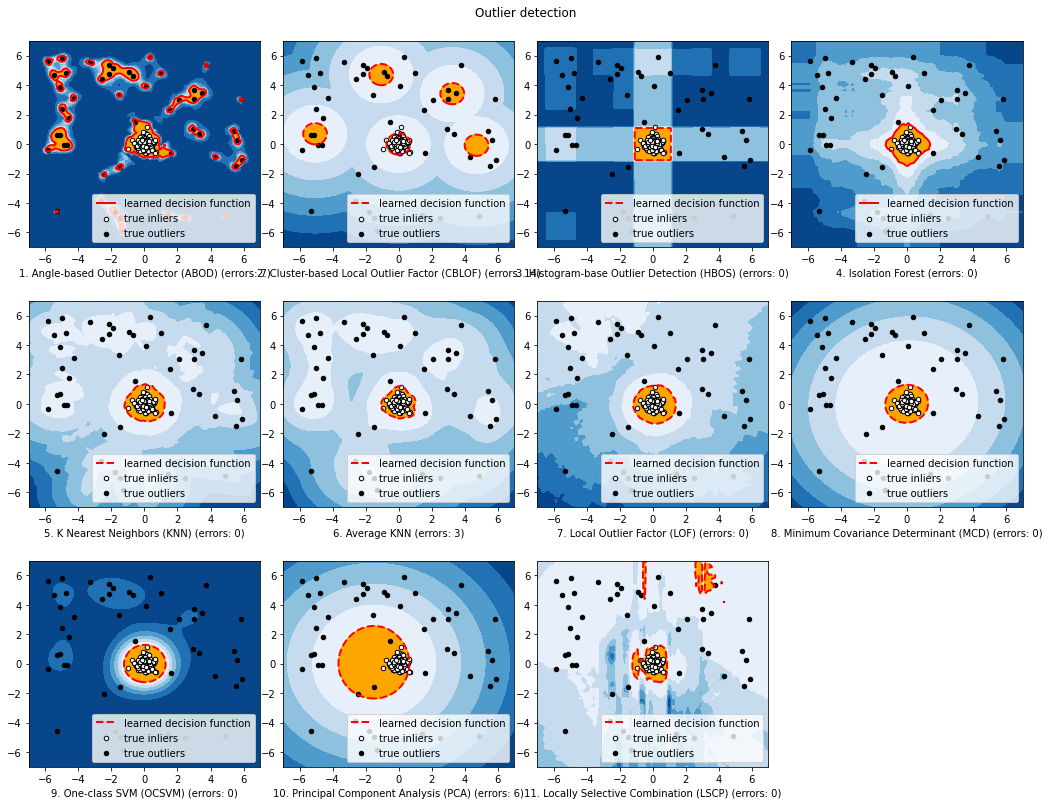

In [18]:
# Fit the models with the generated data and 
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # 生成随机的正常点
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]# 垂直拼接
    # 添加异常点
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 12))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()

# 异常检测

In [26]:
# 模型保存
from joblib import dump, load
import os
anomaly_path = 'anomaly_model/'

In [8]:
# 采样一部分来训练异常检测
X_sample = X_train.sample(10000)
X_sample

,1,10,11,12,13,14,15,16,17,18,...,26,27,28,3,4,5,6,7,8,9
75189,1.100434,1.031527,0.694592,-1.313488,2.214872,0.762021,-1.591852,-0.953790,0.000000,1.316589,...,0.665789,0.841029,0.809474,-0.957379,0.296255,0.522156,1.163961,1.179338,0.650443,0.000000
95967,1.020825,0.819506,0.274959,-0.825238,1.107436,0.485593,0.659193,-1.526277,0.000000,0.913264,...,0.702216,0.644382,0.593984,0.239562,0.509085,-1.013989,0.287097,0.457461,0.693684,2.173076
11694,0.321547,0.784253,-0.206842,-0.744788,2.214872,0.825947,1.136163,1.102165,0.000000,1.224338,...,0.936231,0.812508,0.753450,0.947010,1.106538,-0.828944,0.556697,-0.148560,1.301834,2.173076
86562,0.966105,0.383880,1.214277,0.039847,2.214872,0.828230,0.563617,0.602348,1.274112,0.788639,...,0.348698,0.737435,0.914620,-1.287522,2.507680,1.652658,1.084263,1.787340,0.048946,0.000000
52261,1.154787,0.936218,0.877211,-0.823019,0.000000,1.282387,-0.472246,1.151536,0.000000,1.310748,...,1.017366,0.920840,0.822785,1.638367,1.534073,1.239756,0.888956,0.877318,-1.194623,2.173076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119147,0.562387,0.645255,0.536259,-0.960061,0.000000,0.558651,0.880383,1.078866,0.000000,0.391155,...,0.738694,0.824718,0.749772,-0.084025,1.535951,-1.122548,1.242285,-0.278280,0.811212,2.173076
51780,0.578126,0.495556,-0.162159,1.188900,2.214872,0.642598,0.934998,-0.961001,0.000000,0.406247,...,0.559821,0.539449,0.501690,0.743376,0.507992,0.178328,0.405728,-0.418893,-1.192406,1.086538
123941,1.283809,1.228189,-0.675044,-1.656373,0.000000,1.617473,0.156736,-0.579343,0.000000,1.621335,...,1.904414,1.285619,1.252336,0.316688,1.930890,1.227424,1.073820,-0.757551,-0.700121,1.086538
65437,0.544269,0.867475,0.131196,1.142849,2.214872,1.012808,0.478964,-0.245390,0.000000,1.584094,...,0.857096,0.993822,0.817475,0.640727,0.626795,-1.164434,1.005847,0.128704,-1.501193,0.000000


### ocsvm

In [9]:
clf_name = 'OCSVM'
clf_ocsvm = OCSVM()
clf_ocsvm.fit(X_sample)
 
y_sample_pred = clf_ocsvm.labels_
y_sample_scores = clf_ocsvm.decision_scores_

In [27]:
dump(clf_ocsvm, os.path.join(anomaly_path, 'clf_ocsvm_sample_10000.joblib'))

['anomaly_model/clf_ocsvm_sample_10000.joblib']

In [10]:
# 预测rsp32的异常值
y_rsp32_pred = clf_ocsvm.predict(X_rsp32)
y_rsp32_scores = clf_ocsvm.decision_function(X_rsp32)

In [11]:
print('数据个数: ', X_rsp32.shape[0])
print('异常值个数: ', y_rsp32_pred[y_rsp32_pred==1].shape[0])

数据个数:  154000
异常值个数:  15766


### knn

In [28]:
# clf_name = 'kNN'
clf_knn = KNN()
clf_knn.fit(X_sample)
 
y_sample_pred_knn = clf_knn.labels_
y_sample_scores_knn = clf_knn.decision_scores_

In [29]:
dump(clf_knn, os.path.join(anomaly_path, 'clf_knn_sample_10000.joblib'))

['anomaly_model/clf_knn_sample_10000.joblib']

In [30]:
# 预测rsp32的异常值
y_rsp32_pred_knn = clf_knn.predict(X_rsp32)
y_rsp32_scores_knn = clf_knn.decision_function(X_rsp32)

In [31]:
print('数据个数: ', X_rsp32.shape[0])
print('异常值个数: ', y_rsp32_pred_knn[y_rsp32_pred_knn==1].shape[0])

数据个数:  154000
异常值个数:  15789


### 对rsp 32+42的全体数据进行异常值检测

In [54]:
# 预测rsp32的异常值
y_train_pred_knn = clf_knn.predict(X_train)
y_train_scores_knn = clf_knn.decision_function(X_train)

In [55]:
X_train_tmp = X_train.iloc[y_train_pred_knn != 1,:]
X_train_tmp.shape

(276591, 28)

In [56]:
X_train_tmp.to_csv('rsp 32+42 after anomaly detection.csv')

### 可视化异常检测结果

In [16]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 

def plot_pca(num, data, label, clf=None):
    pca=PCA(n_components=num)
    X_pca=pca.fit_transform(data)
    print(pca.components_)
    # 分割数据
    X_failure=np.array([x for i,x in enumerate(X_pca) if label[i]==1])
    X_healthy=np.array([x for i,x in enumerate(X_pca) if label[i]==0])
    
    if num==3:
        fig = plt.figure(figsize=[10,15])
        ax = Axes3D(fig)   
        #ax.legend(loc='best')
        ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
        ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
        ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
        ax.scatter(X_failure[:,0], X_failure[:,1], X_failure[:,2])
        ax.scatter(X_healthy[:,0], X_healthy[:,1], X_healthy[:,2])
    elif num==2:
        # outliers_fraction = 0.1
        # threshold = percentile(scores_pred, 100 * outliers_fraction)
        # xx, yy = np.meshgrid(np.linspace(-12, 12, 100), np.linspace(-12, 12, 100))
        # Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        # Z = Z.reshape(xx.shape)
        # plt.contourf(
        #     xx, yy, Z,
        #     levels=np.linspace(Z.min(), threshold, 7), 
        #     cmap=plt.cm.Blues_r
        # )
        # a = plt.contour(xx, yy, Z, levels=[threshold],
        #                     linewidths=2, colors='red')
        # plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],
        #                  colors='orange')
        # b = plt.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
        #                     s=20, edgecolor='k')
        # c = plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
        #                     s=20, edgecolor='k')
        # subplot.axis('tight')
        plt.figure(figsize=[10,10])
        plt.scatter(X_failure[:,0],X_failure[:,1])
        plt.scatter(X_healthy[:,0],X_healthy[:,1])
    else:
        print('i do not want to work.....')


In [32]:
from sklearn.preprocessing import StandardScaler
X_norm = StandardScaler().fit_transform(X_rsp32)
X_norm.shape

(154000, 28)

[[ 5.77423046e-02  2.86314958e-01 -1.14960927e-03  1.29367184e-04
   3.27376779e-02  2.15912420e-01 -2.13641710e-03  1.46854981e-04
   1.09913827e-02  1.43224737e-01 -2.19695845e-03 -1.69194571e-05
  -4.04057489e-03 -1.82905303e-02  2.76038792e-01  3.37417997e-01
   3.95625009e-02  2.75847263e-01  2.70410285e-01  4.50691151e-01
   4.35010038e-01  3.41864914e-03  1.31144870e-01 -1.76638657e-04
   3.09205992e-01  1.06647695e-03 -6.45490371e-04 -3.13884505e-04]
 [ 4.26490749e-03 -2.94288174e-03  4.66529984e-01 -6.19144953e-03
  -5.00484168e-04 -6.95426225e-03  4.34771432e-01 -2.42649322e-03
  -3.25355923e-03 -9.51760771e-03  3.72034157e-01  4.75243280e-01
   1.47343081e-03 -1.15195947e-02 -8.60179953e-03 -5.82665884e-03
   1.45725036e-04  1.05453341e-02  9.31542183e-03  5.29165449e-03
   2.94053718e-03  2.83694152e-03 -2.68702985e-04 -5.23533353e-03
   1.19780655e-03  4.77426667e-01  1.06691219e-02  1.65121765e-02]]


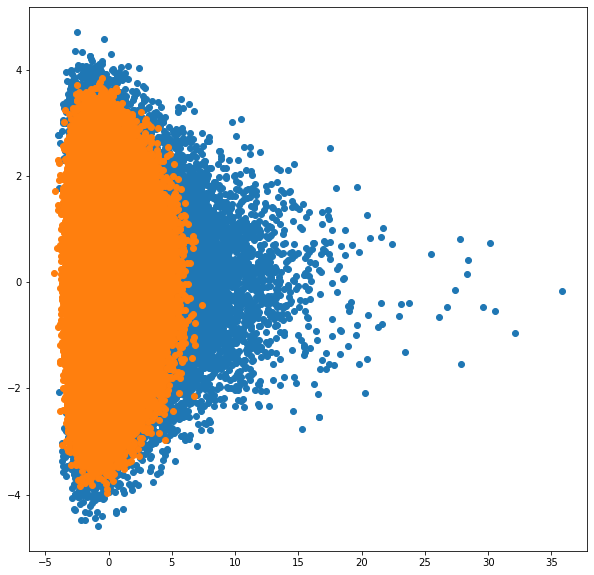

In [21]:
# to visualize the data without the node_path feature
# %matplotlib auto
plot_pca(num=2,data=X_norm,label=y_rsp32_pred)

[[ 5.77410440e-02  2.86317556e-01 -1.15799721e-03  1.25239278e-04
   3.27415314e-02  2.15909145e-01 -2.13167630e-03  1.51377434e-04
   1.09924829e-02  1.43218668e-01 -2.19085357e-03 -2.19022239e-05
  -4.04034836e-03 -1.82910607e-02  2.76039190e-01  3.37417627e-01
   3.95612008e-02  2.75847349e-01  2.70407319e-01  4.50690746e-01
   4.35010565e-01  3.41841820e-03  1.31149820e-01 -1.75807123e-04
   3.09208954e-01  1.07035742e-03 -6.45954856e-04 -3.18721832e-04]
 [ 3.85112859e-03 -4.18045097e-03  4.68959702e-01 -7.31413707e-03
  -1.58966748e-03 -6.47338965e-03  4.33334533e-01 -3.23869892e-03
  -4.43966261e-03 -7.49628920e-03  3.70469616e-01  4.76294382e-01
   1.35249660e-03 -1.00075391e-02 -8.63129449e-03 -5.79726206e-03
  -3.98055499e-04  1.12526544e-02  9.55599145e-03  5.56952358e-03
   3.18079275e-03  3.33763459e-03 -7.09791138e-04 -2.31575072e-03
   4.95297301e-05  4.76530005e-01  1.01482245e-02  1.75246379e-02]]


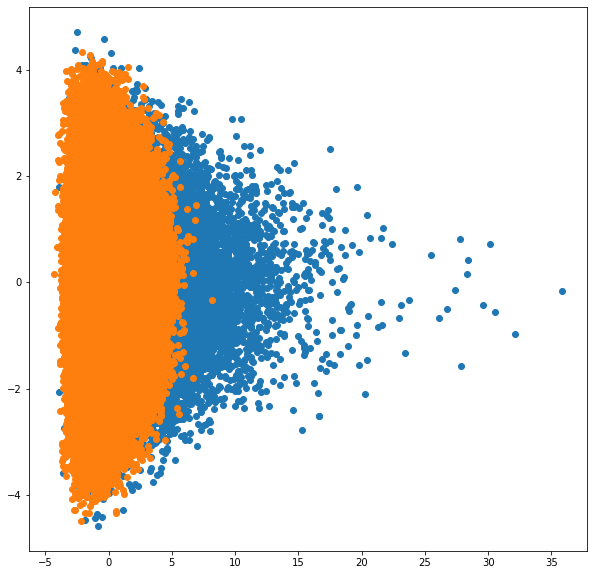

In [36]:
# to visualize the data without the node_path feature
%matplotlib inline
plot_pca(num=2,data=X_norm,label=y_rsp32_pred_knn)

[[ 5.98965500e-02  2.87374038e-01 -1.16328128e-03 -9.36335694e-05
   3.24274748e-02  2.16037356e-01 -9.14684858e-04  6.73115855e-04
   1.13881529e-02  1.44637426e-01 -9.22648417e-04  4.16314180e-04
  -2.85098411e-03 -1.78174387e-02  2.75312065e-01  3.36156477e-01
   3.92911733e-02  2.74689040e-01  2.71740043e-01  4.50903335e-01
   4.35237493e-01  1.37122763e-03  1.29882411e-01 -9.45348947e-04
   3.08981155e-01  1.85908373e-04 -6.29223576e-04 -1.60749907e-04]
 [-2.88612915e-05  1.56373506e-03  4.65773911e-01 -5.35456432e-03
  -2.15285114e-03  2.96786102e-03  4.33926737e-01 -3.95521969e-03
   1.12977112e-03 -1.04335156e-03  3.71665599e-01  4.77877277e-01
  -1.24727422e-03 -4.41650404e-03 -4.87157783e-03 -2.77513159e-03
  -9.12617781e-04  1.19350712e-03  5.65407754e-03  4.90348972e-04
  -4.02198731e-04  1.93951653e-04 -2.38290234e-03 -3.05557073e-03
   2.41058557e-03  4.77489516e-01  8.22049304e-03  5.08630998e-03]]


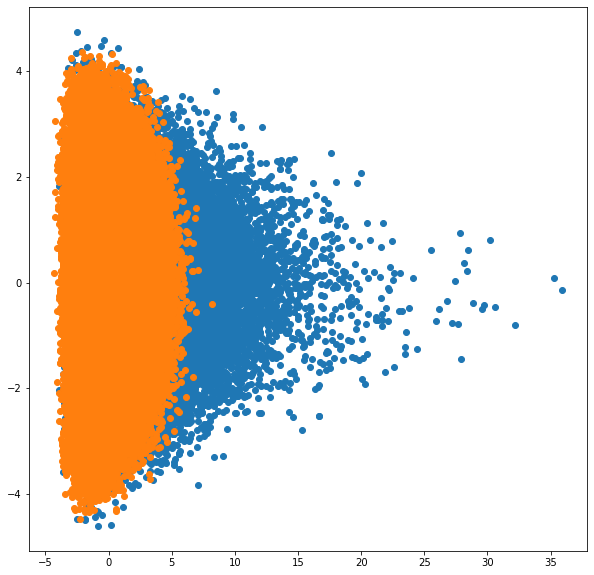

In [57]:
from sklearn.preprocessing import StandardScaler
X_norm = StandardScaler().fit_transform(X_train)
X_norm.shape
# to visualize the data without the node_path feature
%matplotlib inline
plot_pca(num=2,data=X_norm,label=y_train_pred_knn)